# Tarea 5: Ajuste de hiperpaŕametros utilizando Tensorflow y Tensorboard

<font size=4>Como hemos comentado en clase, las redes neuronales actualizan los parámetros necesarios, según cada estilo de arquitectura de red especificada, para atacar un problema particular y poder realizar inferencias relacionadas con dicho problema. Ya en el curso hemos visto, y seguiremos viendo, arquitecturas diversas para atacar un gran número de problemas reales. Pero tenemos que tratar otro asunto...

<font size=4>Un problema abierto en Machine Learning es la selección de hiperpaŕametros. Existen diversas técnicas para atacar el problema. Vas a desarrollar un código, para aplicar un **Grid Search** sobre ciertos conjuntos de hiperparámetros, para determinar el mejor algoritmo que resuelva el problema de clasificación para un nuevo dataset que vas a trabajar: Fashion MNIST 

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-Fashion-MNIST-Dataset-1024x768.png)

<font size=4>Te pedimos, por favor, que tengas a la mano tus notebooks 8, 9 y 10, para resolver la tarea. Te haremos señalizaciones puntuales de dónde consultar cada pregunta. Habrá otras cosas que tendrás que desarrollar por tu cuenta, pero el esfuerzo valdrá la pena. Queremos que este código te permita trabajar tu proyecto final con mucha soltura y con varios experimentos a la vez.

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

<font size=4>Importamos las librerías básicas que necesitamos para esta tarea. 

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import numpy as np
import pickle
import time

from tensorboard.plugins.hparams import api as hp
np.random.seed(1)

%matplotlib inline

2023-04-23 15:56:43.490802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 15:56:43.654657: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 15:56:43.657288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-23 15:56:43.657299: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

<font size=4 color=red>1. Carga los datos de FashionMNIST y separa en los respectivos conjuntos de entrenamiento y test. (HINT: Revisar la parte de preprocesamiento del notebook 10).

In [5]:
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

<font size=4 color=red>2. Obtener la dimensión de cada conjunto de la celda anterior. (HINT:Revisar la clase 10, en la misma sección de procesamiento del dataset)

In [6]:
print('The shape of x_train is', x_train.shape)
print('The shape of y_train is', y_train.shape)

print('\nThe shape of x_test is', x_test.shape)
print('The shape of y_test is', y_test.shape)

The shape of x_train is (60000, 28, 28)
The shape of y_train is (60000,)

The shape of x_test is (10000, 28, 28)
The shape of y_test is (10000,)


<font size=4 color=red> 3. [Ingresa a este link](https://www.kaggle.com/datasets/zalando-research/fashionmnist) para encontrar la información de lo que significa cada una de las etiquetas. Completa el diccionario que se presenta en la siguiente celda.

In [7]:
dic = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
       5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

Ankle boot is the object corresponding to the sample 0

 This is its image


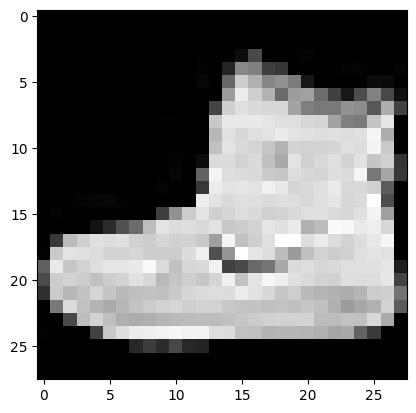

In [8]:
index = 0

plt.imshow(x_train[index], cmap='gray')

print(dic[y_train[index]], "is the object corresponding to the sample", index)
print("\n This is its image")

<font size=4 color=red>4. Analizar si los pixeles de cada imagen están normalizados o no. De no estarlo, hacer la normalización correspondiente. (HINT: Revisar la sección "Analyzing the data extracted from CIFAR-10" del notebook 10)

In [9]:
print("The features of a training sample goes from", np.min(x_train[index]), 'to', np.max(x_train[index]))
if np.max(x_train[index]) > 1:
    print('It is not normalized.')

The features of a training sample goes from 0 to 255
It is not normalized.


In [10]:
# debemos normalizar los datos de tal forma que 
# los elementos del arreglo de la entrada vayan de 0 a 1
train_x = x_train/255
test_x = x_test/255

<font size=4 color=red>5. Realizar la codificación One-Hot para las etiquetas de este problema. (HINT: Revisar la sección "One Hot Encoding" de los notebooks 8, 9 o 10)

In [11]:
# podemos seguir el ejemplo de los notebooks mencionados
# o usar la funcion OneHotEncoder de scikit-learn

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
train_y = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
test_y  = enc.transform(y_test.reshape(-1, 1)).toarray()

In [12]:
# inicialmente
y_train[0:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [13]:
# one-hot encoding
train_y[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

<font size=5 color="blue">

Building the Learning System



<font size=5 color='blue'>

Definition of the neural network architecture

<font size=4>En esta sección vamos a utilizar la arquitectura expuesta en la clase 9, pero vamos a realizar algunas modificaciones para realizar más variaciones al modelo base, así como a otro conjunto de hiperparámetros. A continuación, se expone la manera de realizar estos cambios. No tienes que modificar nada aún.

<font size=4>Primero, se deben inicializar los hiperparámetros, así como sus posibles valores que pueden tomar. Además, vamos a guardar en el Tensorboar el accuracy, de modo que podamos asociar a cada conjunto de hiperparámetros un valor de accuracy, para así comparar y decidir cuál modelo nos puede proporcionar la mejor inferencia. 

In [14]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_LEARNINGRATE= hp.HParam('learning_rate', hp.Discrete([0.1,0.01,0.001]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_LEARNINGRATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

2023-04-23 15:56:53.111899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-23 15:56:53.111916: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-23 15:56:53.111928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hinostra): /proc/driver/nvidia/version does not exist
2023-04-23 15:56:53.112108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<font size=4>Ahora sí, te va a tocar modificar ciertas partes de la arquitectura del código, para realizar la variación de parámetros que se propone en la celda anterior. Te vamos a ayudar con algunos, pero otros tú los vas a tener que modificar. Sigue con cuidado las instrucciones, y obtendrás el resultado esperado.

<font size=4 color=red>6. Se te proporciona a continuación la arquitectura de la clase 9. Modifica el código, de tal forma que reciba como parámetros de entrada la probabilidad de aplicar el Dropout, así como el número de neuronas presentes en la segunda capa lineal. Nosotros te ayudamos a cambiar el número de neuronas. Declaramos una variable de entrada llamada **units**, y lo colocamos en donde corresponde. Lo mismo tienes que hacer para la probabilidad del Dropout(es decir,en cada punto donde encuentres p=0, tienes que cambiarlo por una variable de entrada, de modo que podamos barrer otros valores en este punto)

In [15]:
def architecture(input_shape, num_classes, units, dropout=True, p_drop=0):
    
    # Defining the input as a tensor with shape input_shape. 
    InputLayer = Input(input_shape)
    
    # Flattening the input tensor of dimensions (32, 32, 3) to a tensor of dimensions (3072)
    x = Flatten()(InputLayer)
    if dropout == True:
        x = Dropout(p_drop)(x)  # yo tengo la ultima version de keras, en esta 'p' se reemplaza por 'rate'
    
    # Defining the first hidden layer with 50 nodes and sigmoid as activation function
    x = Dense(50, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_1')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)

    x = Dense(units, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_2')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)
    
    # For the output layer we use the activation function 'softmax')
    x = Dense(num_classes, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    OutputLayer = Activation('softmax', name='output-layer')(x)
    
    # This creates the Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = InputLayer, outputs = OutputLayer, name='FashionMNISTModel')

    return model

<font size=4 color=red>7. Vamos a definir una función llamada train_test_model, en donde vamos a definir todos los pasos importantes para realizar el entrenamiento. La única línea de código que vas a modificar, es la línea 17 de la siguiente celda. Vamos a loggear al Tensorboard el accuracy sobre el conjunto de evaluacion. Aplica el método **evaluate** sobre los conjuntos de prueba. (HINT: Revisa los notebooks 8,9 y 10 para que veas la manera de hacer esto)

In [16]:
one_image = (28, 28, 1)
num_classes=10


def train_test_model(hparams):

    model=architecture(input_shape=one_image, num_classes=num_classes, 
                       p_drop=hparams[HP_DROPOUT], units=hparams[HP_NUM_UNITS])
    model.compile(
          optimizer=hparams[HP_OPTIMIZER],
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )
    model.optimizer.learning_rate=hparams[HP_LEARNINGRATE]
    model.fit(x_train, train_y, epochs = 5, batch_size = 32, \
                                validation_split = 0.1, shuffle=True, verbose=0) # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(x = test_x, y = test_y)
    return accuracy

<font size=4> En la siguiente función, vamos a compactar todo lo que queremos pasarle a nuestro Tensorboard, incluyendo los hiperparámetros y una ruta donde se guardarán todos los resultados. No tienes que modificar nada

In [17]:
def training(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

<font size=4>Finalmente, en la siguiente celda realizamos los entrenamientos sobre todas las posibilidades de hiperparámetros a probar. Nótese que solo correremos 5 épocas. Queremos encontrar un modelo tal que nos ofrezca la mejor solución al problema de clasificación. Solo ejecuta la siguiente celda.

In [18]:
from collections import OrderedDict, namedtuple
from itertools import product
session_num = 0

class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run=namedtuple('Run', params.keys())

        runs=[]

        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs
    
params=OrderedDict(
        num_units=[num_units for num_units in HP_NUM_UNITS.domain.values],
        p_drop=[dropout_rate for dropout_rate in (HP_DROPOUT.domain.values)],
        optim=[optimizer for optimizer in HP_OPTIMIZER.domain.values],
        lr=[lr for lr in HP_LEARNINGRATE.domain.values],
    )

for run in RunBuilder().get_runs(params):
    hparams = {
          HP_NUM_UNITS: run.num_units,
          HP_DROPOUT: run.p_drop,
          HP_OPTIMIZER: run.optim,
          HP_LEARNINGRATE: run.lr
      }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    training('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1


--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001}
313/313 [==============================] - 0s 669us/step - loss: 0.9113 - accuracy: 0.6193
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.01}
313/313 [==============================] - 0s 745us/step - loss: 1.5240 - accuracy: 0.3159
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.1}
313/313 [==============================] - 0s 701us/step - loss: 2.1532 - accuracy: 0.1825
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 0.001}
313/313 [==============================] - 0s 701us/step - loss: 2.3020 - accuracy: 0.1000
--- Starting trial: run-4
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 0.01}
313/313 [==============================] - 0s 764us/step - loss: 1.7243 - accuracy: 0.1994
--- Starting trial: run-5


## Visualización de los resultados en Tensorboard

The HParams dashboard can now be opened. Start TensorBoard and click on "HParams" at the top.

In [19]:
%tensorboard --logdir logs/hparam_tuning

<font size=4>En las pestañas del lado superior izquierdo, hay una llamada HPARAMS. Ingresa en esa pestaña. También en las pestañas de la parte superior de esta pestaña, encontrarás una opción llamada Parallel Coordinates View. En esa opción podrás ver de manera interactiva las diferentes opciones de variación, y su respectivo valor de precisión en Inferencia.

<font size=4 color=red> 8. En el menú interactivo del lado izquierdo, hasta abajo viene una opción que dice: "Download data as CSV". Descarga estos datos y anexalos al momento de subir tu notebook al Classroom. Nota que a pesar de que se tiene una semilla para reproducibilidad, no se obtienen los mismo resultados una vez se ejecuten nuevamente los resultados. Por ello, si alguien te pasa su CSV, nos daremos inmediatamente cuenta, porque no es posible que salgan dos juegos de datos iguales :)

<font size=4 color=red>9. De los tres mejores modelos que obtuviste en esta prueba básica, realiza un entrenamiento completo de 30 épocas con alguno de ellos, como lo realizamos en la clase. A continuación te enumeramos los pasos a seguir para este punto, pero recuerda checar con cuidado los parámetros que debes modificar en cada paso, de modo que pongas los hiperparámetros óptimos que te permitieron obtener el mejor resultado de accuracy en el conjunto test. 

In [20]:
# no correr esta celda, es solo para que yo (Alejandra) pueda visualizar los datos
from pandas import read_csv
df_hpars = read_csv('./hparams_table_hw5.csv')
print('Los tres mejores modelos')
df_hpars.nlargest(3, ['Accuracy'])

Los tres mejores modelos


,num_units,dropout,optimizer,learning_rate,Accuracy
22,32.0,0.1,adam,0.001,0.7173
13,32.0,0.4,adam,0.001,0.6447
1,16.0,0.1,adam,0.001,0.6193


In [21]:
top1_hpars = {'n_units': 32, 'p_drop': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001}
top2_hpars = {'n_units': 16, 'p_drop': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001}
top3_hpars = {'n_units': 32, 'p_drop': 0.4, 'optimizer': 'adam', 'learning_rate': 0.001}

In [22]:
# elegimos el mejor modelo con hiperparametros top1_hpars

n_units   = top1_hpars['n_units']
p_drop    = top1_hpars['p_drop']

def architecture(input_shape, num_classes, dropout=True):
    
    # Defining the input as a tensor with shape input_shape. 
    InputLayer = Input(input_shape)
    
    # Flattening the input tensor of dimensions (32, 32, 3) to a tensor of dimensions (3072)
    x = Flatten()(InputLayer)
    if dropout == True:
        x = Dropout(p_drop)(x)
    
    # Defining the first hidden layer with 50 nodes and sigmoid as activation function
    x = Dense(50, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_1')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)

    # Defining the second hidden layer with 'n_units' nodes and sigmoid as activation function
    x = Dense(n_units, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_2')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)
    
    # For the output layer we use the activation function 'softmax')
    x = Dense(num_classes, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    OutputLayer = Activation('softmax', name='output-layer')(x)
    
    # This creates the Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = InputLayer, outputs = OutputLayer, name='FashionMNISTModel')

    return model

<font size=4 color=red>En la celda anterior, recuerda poner la probabilidad de Dropout y el número de neuronas de salida en la segunda capa lineal que mejor funcionaron para ti

In [23]:
best_model = architecture((28,28,1), 10)

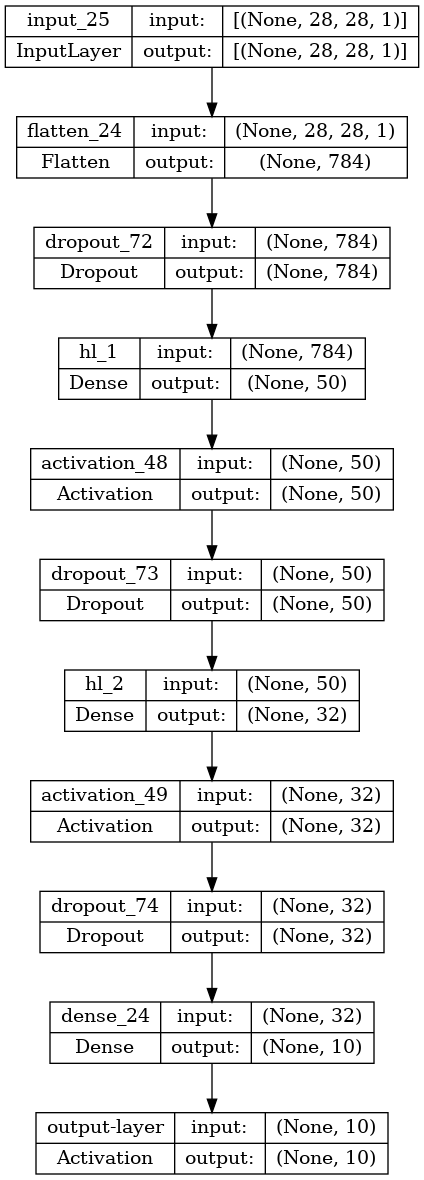

In [24]:
plot_model(best_model, to_file='best_model.png', show_shapes=True, rankdir='TB', show_layer_names=True)

In [25]:
best_model.summary()

Model: "FashionMNISTModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 dropout_72 (Dropout)        (None, 784)               0         
                                                                 
 hl_1 (Dense)                (None, 50)                39250     
                                                                 
 activation_48 (Activation)  (None, 50)                0         
                                                                 
 dropout_73 (Dropout)        (None, 50)                0         
                                                                 
 hl_2 (Dense)                (None, 32)          

In [26]:
from keras.optimizers import Adam

learning_rate = top1_hpars['learning_rate']
optimizer     = Adam(learning_rate=learning_rate)

<font size=4 color=red>Ahora, también cambia en la anterior celda el learning rate y el optimizador que mejor funcionaron para ti

In [27]:
loss_function   = 'categorical_crossentropy'
metric_function = 'accuracy'

In [28]:
best_model.compile(optimizer = optimizer, loss = loss_function, metrics = [metric_function])

In [29]:
#10 % of the training data will be used to validate the training
start_time = time.time()

validation_portion = 0.1
batch_size = 128
num_epochs = 30

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="logs/best_model", histogram_freq=1)

history = best_model.fit(x=x_train, y=train_y, epochs=num_epochs, batch_size=batch_size, \
                            validation_split=validation_portion, shuffle=True,
                            callbacks=[tensorboard_callback], verbose=1)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/30
422/422 [==============================] - 1s 3ms/step - loss: 1.6465 - accuracy: 0.3753 - val_loss: 1.2000 - val_accuracy: 0.5747
Epoch 2/30
422/422 [==============================] - 1s 2ms/step - loss: 1.1463 - accuracy: 0.5144 - val_loss: 1.0331 - val_accuracy: 0.5905
Epoch 3/30
422/422 [==============================] - 1s 2ms/step - loss: 1.0066 - accuracy: 0.6089 - val_loss: 0.8570 - val_accuracy: 0.6970
Epoch 4/30
422/422 [==============================] - 1s 2ms/step - loss: 0.8872 - accuracy: 0.6598 - val_loss: 0.7933 - val_accuracy: 0.7008
Epoch 5/30
422/422 [==============================] - 1s 2ms/step - loss: 0.8356 - accuracy: 0.6781 - val_loss: 0.7324 - val_accuracy: 0.7423
Epoch 6/30
422/422 [==============================] - 1s 2ms/step - loss: 0.7970 - accuracy: 0.6953 - val_loss: 0.6893 - val_accuracy: 0.7478
Epoch 7/30
422/422 [==============================] - 1s 2ms/step - loss: 0.7815 - accuracy: 0.7016 - val_loss: 0.7022 - val_accuracy: 0.7210
Epoch 

<font size=4 color=red> 10. Realiza las gráficas de costo y accuracy para cada conjunto, entrenamiento y validación. Explica si tu modelo presenta overfitting, underfitting o si es un buen modelo. Argumenta lo mejor que puedas tu respuesta. (HINT: Revisa la clase 10 para realizar estas gráficas. Añade un título descriptivo de tu experimento a cada gráfica, como se hace en específico en esta notebook.)

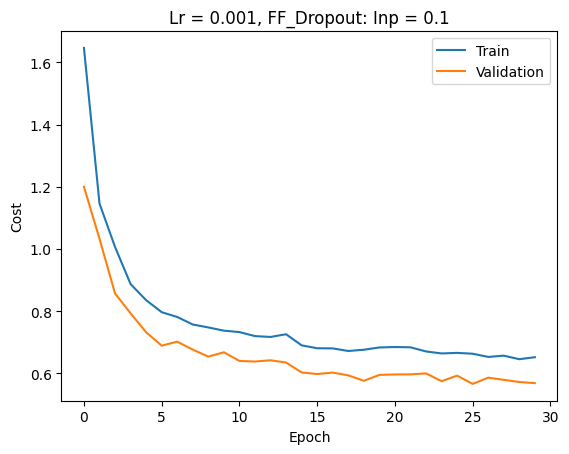

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Lr = 0.001, FF_Dropout: Inp = 0.1')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

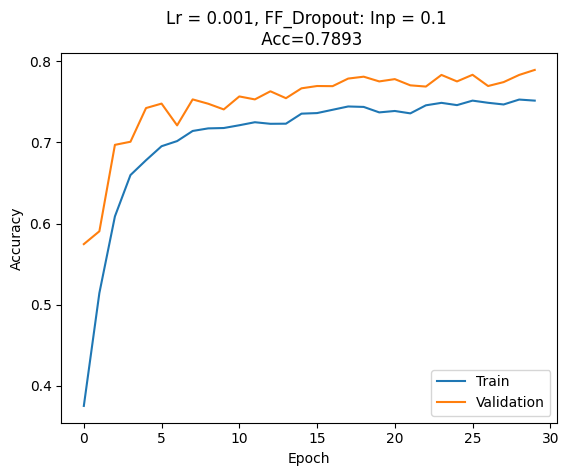

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Lr = 0.001, FF_Dropout: Inp = 0.1 \n Acc=0.7893')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [35]:
# Evaluamos el modelo
evaluations = best_model.evaluate(x=test_x, y=test_y)
print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

313/313 [==============================] - 0s 670us/step - loss: 0.5848 - accuracy: 0.7802
Loss = 0.5848091840744019
Test Accuracy = 0.7802000045776367


# Puntos Extras!!!

<font size=5 color=blue> E1. Modifica los valores que se proponen en la celda 14, donde definimos los hiperparámetros a varias, y realiza la variación de parámetros. Si encuentras un modelo que obtenga más del 90% de accuracy en test, realiza un entrenamiento completo, y haz el análisis sobre el under-overfitting. Anexa en tu tarea para obtener el punto extra el CSV del Tensorboard, así como el modelo. (+1)